In [ ]:
# default_exp dahmen

# Code for the Dahmen instances

> API details.


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

import importlib
from personnel_scheduling.data_structures import *
from personnel_scheduling.reporting import *
from collections import namedtuple
from pulp import *
from box import Box

from dataclasses import dataclass, field

## Instance class


In [ ]:
#export

class DahmenInstance():
        
    def __init__(self, filename):
        
        self.instance_name = filename[filename.rfind('/')+1:-4]
        
        with open(filename) as f:

            self.period = int(f.readline()[7:])
            self.number_of_periods = int(f.readline()[14:])
            self.number_of_days_in_horizon = int(f.readline()[8:])
            self.number_of_employee_types = int(f.readline()[16:])
            self.flex_type_activities = int(f.readline()[6:])
            self.demand_profile_type = int(f.readline()[6:])
            self.typ_param = int(f.readline()[9:])
            self.interval_shift_start = int(f.readline()[3:])
            self.number_of_shift_types = int(f.readline()[14:])

            self.shift_type_data = []

            for shift_type in range(self.number_of_shift_types):
                line = f.readline()[:-1].split()
                shift_data = Box({'index' : int(line[1]), \
                                  'min_length_pre' : int(line[3]), \
                                  'max_length_pre' : int(line[5]), \
                                  'break_length' : int(line[7]), \
                                  'min_length_post' : int(line[9]), \
                                  'max_length_post' : int(line[11]), \
                                  'min_length' : int(line[13]), \
                                  'max_length' : int(line[15]), \
                                  'number_of_starts' : int(line[17]), \
                                  'starts' : [int(n) for n in line[19:]]})

                self.shift_type_data.append(shift_data)

            # sort of a hack: here, we assume that shift length only varies with break length
            self.break_length_to_shift_data = {}

            for shift_data in self.shift_type_data:
                self.break_length_to_shift_data[shift_data.break_length] = shift_data


            self.number_of_activities = int(f.readline()[8:])            

            min_length = self.number_of_periods

            max_length = 0

            self.activity_data = []
            for act in range(self.number_of_activities):
                line = f.readline()[:-1].split()
                activity_data = Box({'index' : int(line[1]), \
                                     'min_length' : int(line[3]), \
                                     'max_length' : int(line[5]), \
                                     'demand' : [int(n) for n in line[7:]]})

                self.activity_data.append( activity_data )

                min_length = min(min_length, activity_data.min_length)
                max_length = max (max_length, activity_data.max_length)

            self.min_length_activities = min_length
            self.max_length_activities = max_length

            self.is_cyclical = False
        
    def get_aggregated_demand_per_period(self):
        demand_per_period = []
        for p in range(self.number_of_periods):
            demand = 0
            for act in range(self.number_of_activities):
                demand = demand + self.activity_data[act].demand[p]

            demand_per_period.append(demand)

        return demand_per_period

    def get_activity_demands_per_period(self):
        demands = []

        for activity in range(self.number_of_activities):
            demands.append(self.activity_data[activity].demand)

        return demands   
    
    def get_instance_information(self):
        return f'Info: Activities: {self.number_of_activities}, Periods: {self.number_of_periods}, Shift Types: {self.number_of_shift_types}, Flex Type: {self.flex_type_activities}'  
        
def get_next_period(p,instance):
        
    if (instance.is_cyclical and p >= instance.number_of_periods-1):
        return 0
    return p+1


    
     

In [ ]:
def read_instance(filename):
    with open(filename) as f:
        instance =  Box({'period' : int(f.readline()[7:]), \
                         'number_of_periods' : int(f.readline()[14:]), \
                         'number_of_days_in_horizon' : int(f.readline()[8:]), \
                         'number_of_employee_types' : int(f.readline()[16:]), \
                         'flex_type_activities' : int(f.readline()[6:]), \
                         'demand_profile_type' : int(f.readline()[6:]), \
                         'typ_param' : int(f.readline()[9:]), \
                         'interval_shift_start' : int(f.readline()[3:]),\
                         'number_of_shift_types' : int(f.readline()[14:])
        })

        instance.shift_type_data = []
        
        for shift_type in range(instance.number_of_shift_types):
            line = f.readline()[:-1].split()
            shift_data = Box({'index' : int(line[1]), \
                              'min_length_pre' : int(line[3]), \
                              'max_length_pre' : int(line[5]), \
                              'break_length' : int(line[7]), \
                              'min_length_post' : int(line[9]), \
                              'max_length_post' : int(line[11]), \
                              'min_length' : int(line[13]), \
                              'max_length' : int(line[15]), \
                              'number_of_starts' : int(line[17]), \
                              'starts' : [int(n) for n in line[19:]]})
            
            instance.shift_type_data.append(shift_data)

        # sort of a hack: here, we assume that shift length only varies with break length
        instance.break_length_to_shift_data = {}
        
        for shift_data in instance.shift_type_data:
            instance.break_length_to_shift_data[shift_data.break_length] = shift_data
            

        instance.number_of_activities = int(f.readline()[8:])            

        min_length = instance.number_of_periods

        max_length = 0
        
        instance.activity_data = []
        for act in range(instance.number_of_activities):
            line = f.readline()[:-1].split()
            activity_data = Box({'index' : int(line[1]), \
                                 'min_length' : int(line[3]), \
                                'max_length' : int(line[5]), \
                                'demand' : [int(n) for n in line[7:]]})
            
            instance.activity_data.append( activity_data )

            min_length = min(min_length, activity_data.min_length)
            max_length = max (max_length, activity_data.max_length)

        instance.min_length_activities = min_length
        instance.max_length_activities = max_length
        
        instance.is_cyclical = False
        
        return instance
    
def get_next_period(p,instance):
        
    if (instance.is_cyclical and p >= instance.number_of_periods-1):
        return 0
    return p+1

## read instance
      
    
def get_aggregated_demand_per_period(instance):
    demand_per_period = []
    for p in range(instance.number_of_periods):
        demand = 0
        for act in range(instance.number_of_activities):
            demand = demand + instance.activity_data[act].demand[p]

        demand_per_period.append(demand)

    return demand_per_period

def get_activity_demands_per_period(instance):
    demands = []
    
    for activity in range(instance.number_of_activities):
        demands.append(instance.activity_data[activity].demand)
        
    return demands



Let us read an instance file and create a report.

## Instance: Implicit_Per15_Act3_prAct1_Cur2_Typ1_HD2

Info: Activities: 3, Periods: 96, Shift Types: 1, Flex Type: 1

## Demand:

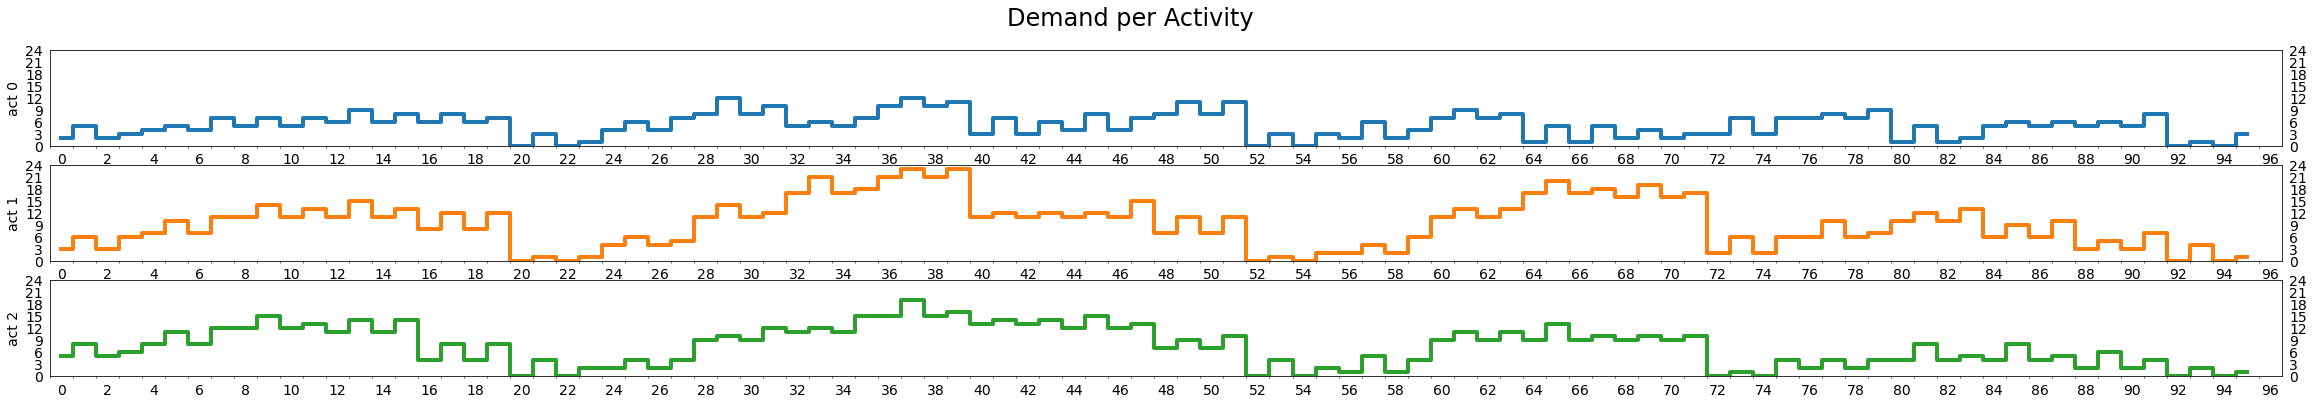

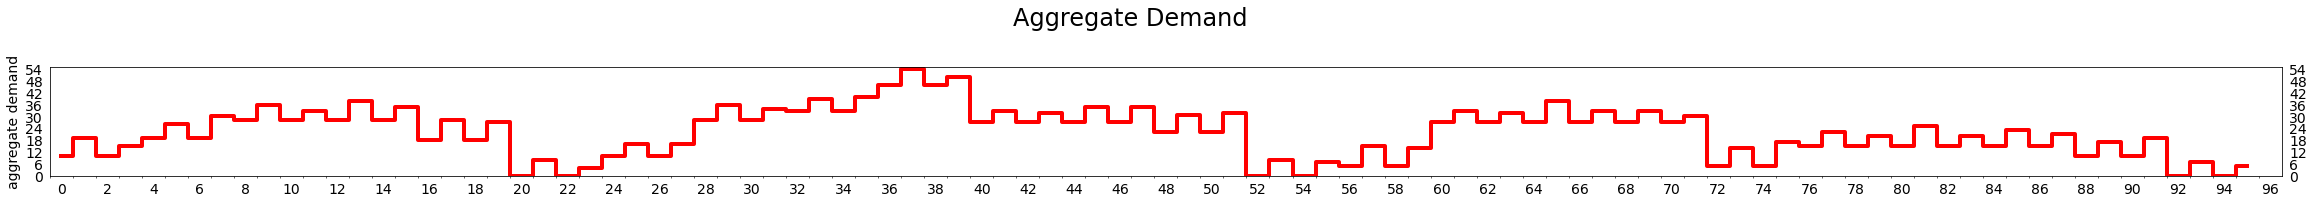

In [ ]:

instance = DahmenInstance("./instances/dahmen/Implicit_Per15_Act3_prAct1_Cur2_Typ1_HD2.txt")

instance_report(instance)


In [ ]:
print (len(instance.activity_data[0].demand))

96


## Rule Sets
  

In [ ]:
#export


class RuleSet:
    
    def __init__(self, instance):
        self.instance = instance
     
    
    def check_activity_block_rules(self, activity_block):
        
        evaluation_result = RuleEvaluationResult()
        
        number_of_periods = activity_block.get_number_of_periods()
        
        

        # if it is a work block: minimum activity
        if activity_block.is_work():
            
            evaluation_result.add_penalty('ActivityCostPerPeriod', activity_block.get_number_of_work_periods())

            if number_of_periods < self.instance.activity_data[activity_block.activity_type].min_length:
                evaluation_result.add_hard_rule_violation('MinConsPeriodsActivity')
                
            elif number_of_periods > self.instance.activity_data[activity_block.activity_type].max_length:
                evaluation_result.add_hard_rule_violation('MaxConsPeriodsActivity')
        else:
            if number_of_periods not in self.instance.break_length_to_shift_data:
                evaluation_result.add_hard_rule_violation('WrongBreakLength')

            
        return evaluation_result
        
    def check_work_block_rules(self, work_block, shift_index = -1):
   
        evaluation_result = RuleEvaluationResult()
        
        prev_block = work_block.activity_blocks[0]
        
        if prev_block is None:
            print ("Prev Block None in shift ", shift_index)
        
        
        # no two different activities after another in one work block
        for block in work_block.activity_blocks[1:]:
            if block is None:
                print ("Block None in shift ", shift_index)
        
            if prev_block.activity_type == block.activity_type:
                evaluation_result.add_hard_rule_violation('TwoConsecutiveActivityBlocksSameActivity')
            
            prev_block = block
        
        
        ## length:
        if work_block.get_number_of_periods() < self.instance.shift_type_data[0].min_length_pre:            
            evaluation_result.add_hard_rule_violation('WorkBlockTooShort')
            
        elif work_block.get_number_of_periods() > self.instance.shift_type_data[0].max_length_pre:
            evaluation_result.add_hard_rule_violation('WorkBlockTooLong')
        
        return evaluation_result
    
    def check_shift_rules(self, shift, shift_index = -1):         
        

        
        evaluation_result = RuleEvaluationResult()
        
    
        hard_rule_violations = []
        
        # shifts are only allowed to start at certain points in time
        if shift.work_and_break_blocks[0].get_start_period() not in self.instance.shift_type_data[0].starts:
            evaluation_result.add_hard_rule_violation('OnlyStartInGivenPeriods') 

        
                
        prev_block = shift.work_and_break_blocks[0]    
        
        number_of_work_periods = prev_block.get_number_of_work_periods()
        
        number_of_break_periods = prev_block.get_number_of_break_periods()
        
        number_of_total_periods = prev_block.get_number_of_periods()
        
        for block in shift.work_and_break_blocks[1:]:
            if prev_block.is_work() == block.is_work():
                evaluation_result.add_hard_rule_violation('BreakAndWorkBlocksNeedToAlternate')
            
            #oberve: given the activity block checks, we know that we can only have 1 and 4 period-breaks
            if not block.is_work():
                number_of_break_periods += block.get_number_of_break_periods()
               
         
            number_of_work_periods += block.get_number_of_work_periods()
            number_of_total_periods += block.get_number_of_periods()
            
            prev_block = block
            
        # now check:
        if number_of_total_periods < self.instance.break_length_to_shift_data[number_of_break_periods].min_length:
            evaluation_result.add_hard_rule_violation(f'Shift {shift_index} too short: {number_of_total_periods} < {self.instance.break_length_to_shift_data[number_of_break_periods].min_length}')
            
        if number_of_total_periods > self.instance.break_length_to_shift_data[number_of_break_periods].max_length:
            evaluation_result.add_hard_rule_violation(f'Shift {shift_index } too long: {number_of_total_periods} < {self.instance.break_length_to_shift_data[number_of_break_periods].max_length}')
        
        return evaluation_result
    
    
    def check_demand_coverage(self, p, activity, covered_demand):
        evaluation_result = RuleEvaluationResult()
        
        difference = covered_demand - self.instance.activity_data[activity].demand[p]
        

        if difference < 0:
            evaluation_result.add_hard_rule_violation(f'Undercover activity: {activity} period {p} cover {covered_demand} < demand {self.instance.activity_data[activity].demand[p]}')
        
        return evaluation_result

        
    

Now, we create the rule set for the instance, read a solution and check the solution and create a report.

## Instance: Implicit_Per15_Act3_prAct1_Cur2_Typ1_HD2

Info: Activities: 3, Periods: 96, Shift Types: 1, Flex Type: 1

### Feasible Solution with objective: 2600

### Grouped Penalties:

rule,penalty
ActivityCostPerPeriod,2600


## Shift Schedule:

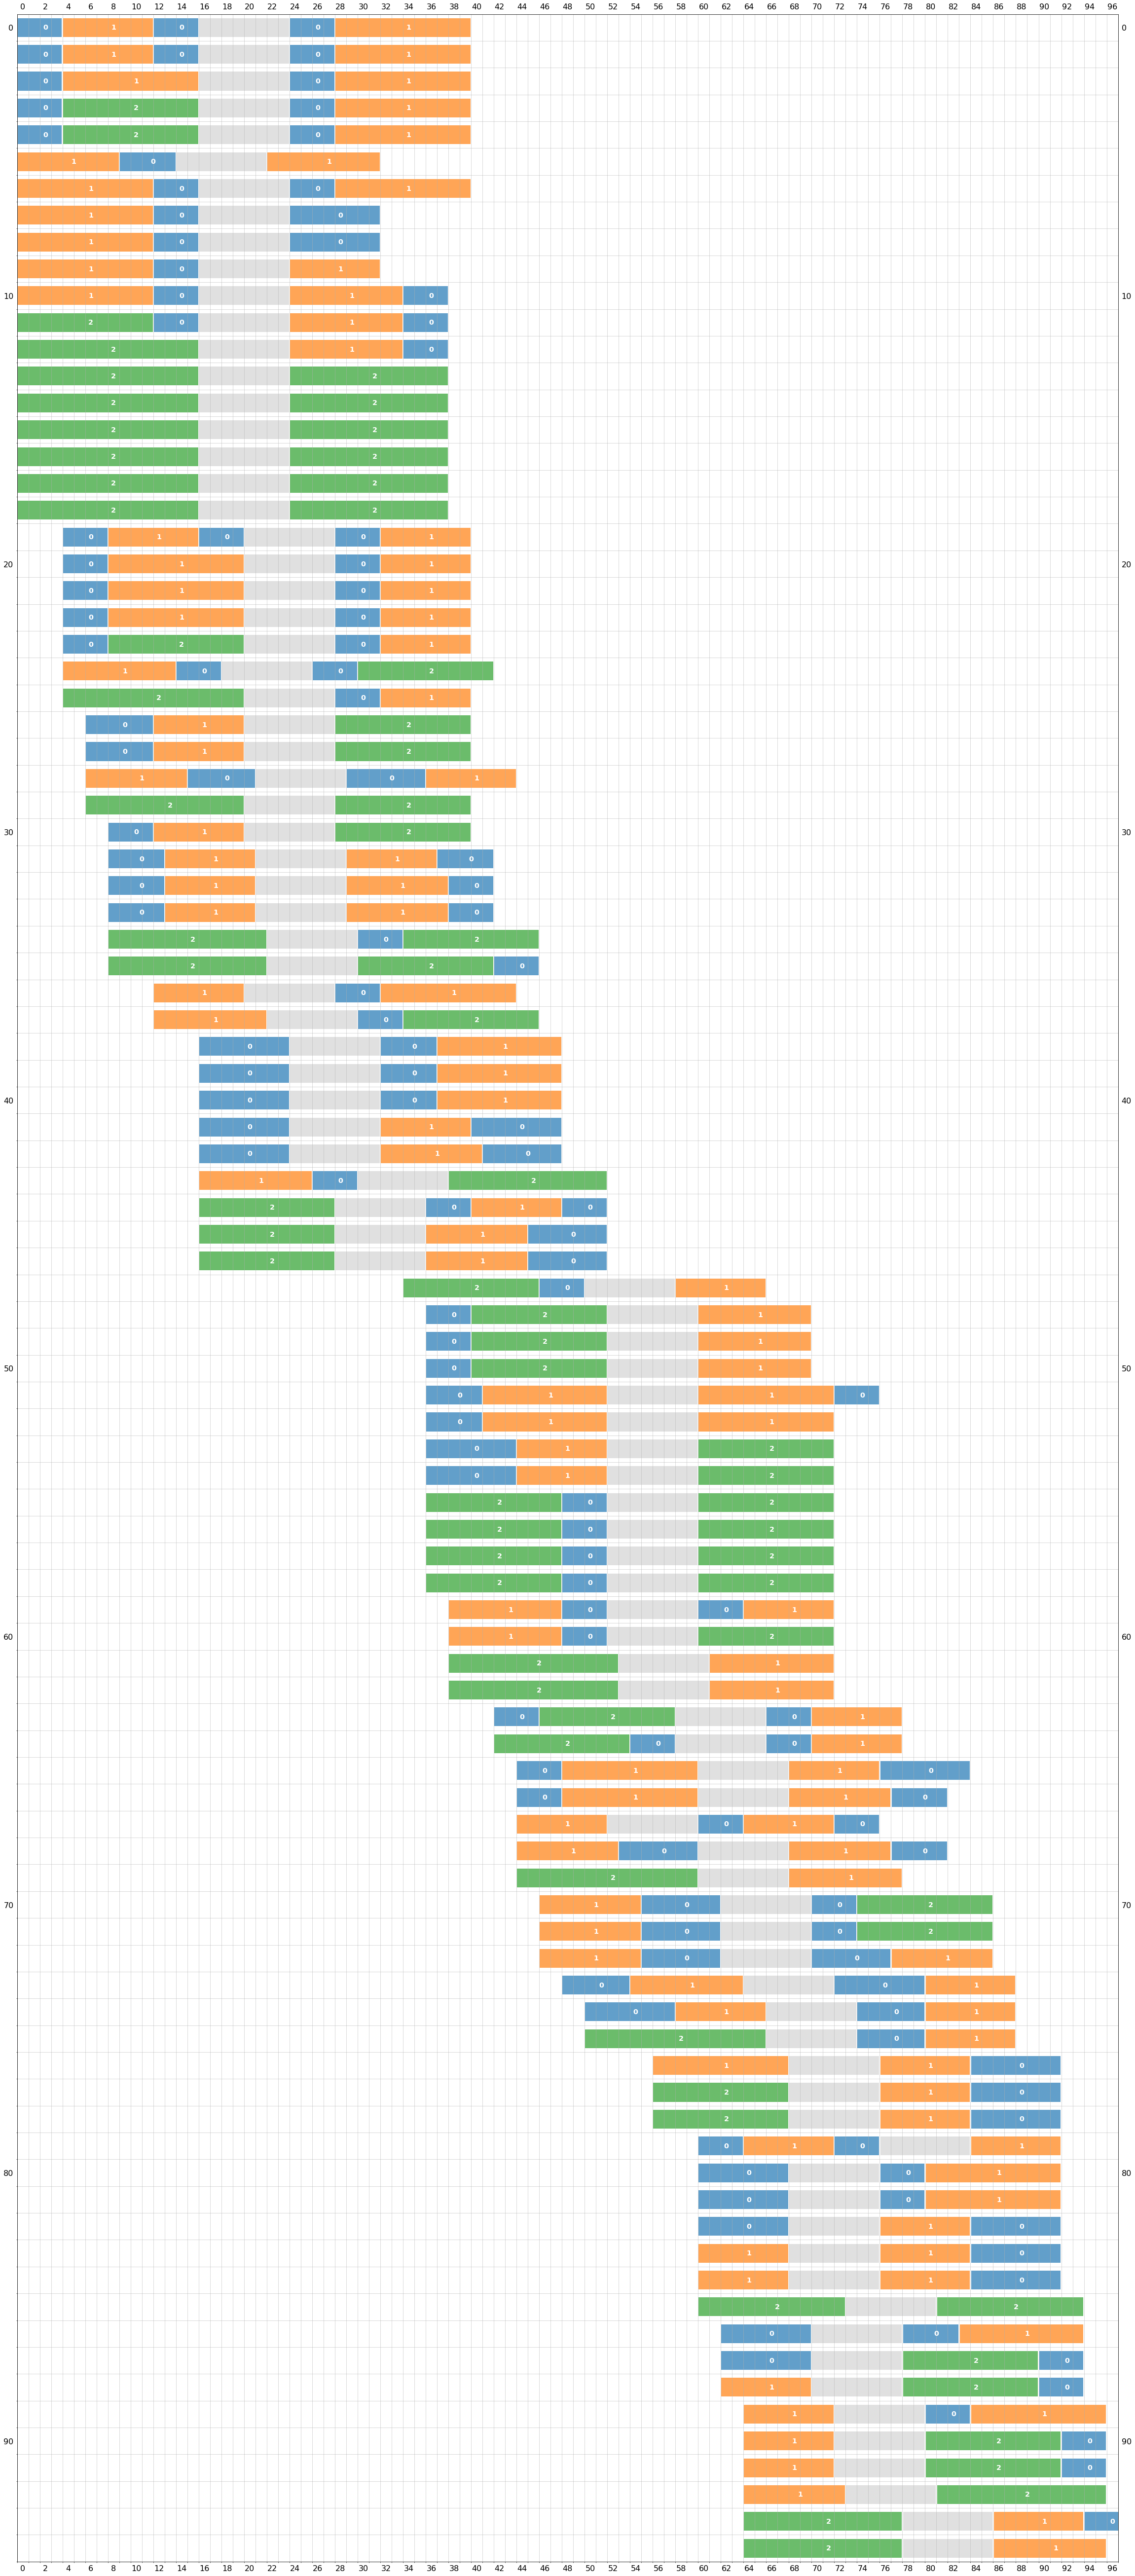

## Demands and Cover

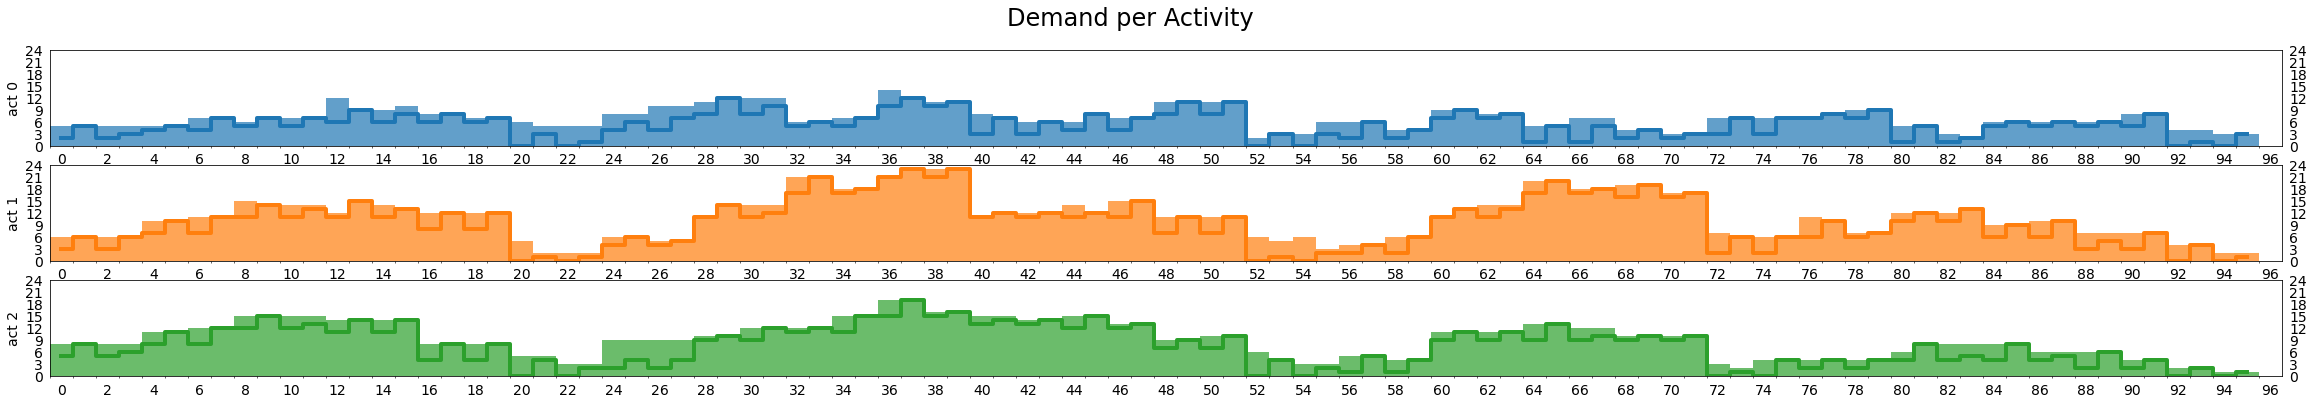

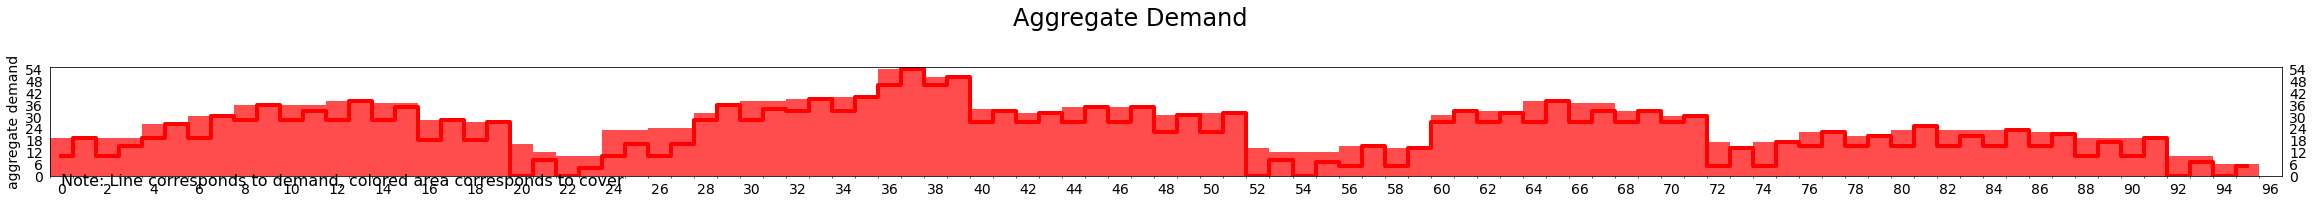

In [ ]:

rule_set = RuleSet(instance)

shift_schedule = ShiftSchedule.from_file("test_data/Implicit_Per15_Act3_prAct1_Cur2_Typ1_HD2_sol.csv")

evaluation_result = evaluate_shift_schedule(shift_schedule, rule_set)

instance_solution_report(instance, rule_set, shift_schedule)



## Exporting

In [ ]:


#hide
from nbdev.export import *
notebook2script()



Converted 00_data_stuctures.ipynb.
Converted 00_reporting.ipynb.
Converted 01_demassey.ipynb.
Converted 02_dahmen.ipynb.
Converted index.ipynb.
